In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib

In [2]:
# Load the dataset
file_path='../data/preproccessed_coffee_prices.csv'
data = pd.read_csv(file_path, index_col='Date', parse_dates=True)

# Replace NaN and infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)  # Drop rows with NaN values
data = data[~data.index.duplicated(keep='first')]

# Display the first few rows
display(data.head())

,index,Symbol,Warehouse,Production Year,Opening Price,Closing Price,High,Low,Change,Persetntage Change,Volume (Ton),Returns,Volatility,Rolling_Corr
Date,,,,,,,,,,,,,,
2013-01-01,15576,UJMB7,BD,2004.0,795.0,795.0,795.0,795.0,5.0,0.0%,33.15,-0.135870,0.444229,0.073990
2013-01-02,16998,UHRB6,DD,2005.0,1830.0,1830.0,1830.0,1830.0,0.0,0.0%,2.55,1.909380,0.743888,0.352166
2013-01-03,12104,WLMA4,JM,2005.0,860.0,880.0,880.0,860.0,52.0,6.0%,67.98,-0.534392,0.773900,0.236028
2013-01-04,16892,UHRC4,DD,2005.0,1340.0,1340.0,1340.0,1340.0,20.0,1.0%,2.55,0.540230,0.660081,0.174173
2013-01-08,10552,WYCAQ2,DL,2005.0,1130.0,1130.0,1130.0,1130.0,20.0,1.0%,7.21,0.412500,0.432203,-0.181592


In [4]:
# Function to perform ADF test
def adf_test(series):
    # Perform the ADF test
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    return result[1] > 0.05  # Returns True if the series is non-stationary

# Filter for float columns and remove those with NaN or inf values
data = data.select_dtypes(include=['float'])  # Keep only float columns
data = data.loc[:, ~data.isin([np.nan, np.inf, -np.inf]).any()]  # Drop columns with NaN or inf

print(f"Remaining columns after filtering: {data.columns.tolist()}")

# Check each series in the dataset
for column in data.columns:
    print(f'ADF Test for {column}:')
    while adf_test(data[column]):  # Perform differencing until the series is stationary
        data[column] = data[column].diff()  # Apply differencing
        data[column] = data[column].dropna()  # Remove NaN values after differencing

Remaining columns after filtering: ['Opening Price', 'Closing Price', 'High', 'Low', 'Change', 'Volume (Ton)', 'Returns', 'Volatility', 'Rolling_Corr']
ADF Test for Opening Price:
ADF Statistic: -4.639062429004748
p-value: 0.00010936782392421909
ADF Test for Closing Price:
ADF Statistic: -4.6425068859934076
p-value: 0.00010776824674179761
ADF Test for High:
ADF Statistic: -4.585036700238229
p-value: 0.0001376259003487094
ADF Test for Low:
ADF Statistic: -4.686827277494708
p-value: 8.908065084727132e-05
ADF Test for Change:
ADF Statistic: -9.514011340771143
p-value: 3.19296455325554e-16
ADF Test for Volume (Ton):
ADF Statistic: -19.186656971214553
p-value: 0.0
ADF Test for Returns:
ADF Statistic: -9.077690272603084
p-value: 4.136369509318795e-15
ADF Test for Volatility:
ADF Statistic: -3.091700001745391
p-value: 0.02717355423273736
ADF Test for Rolling_Corr:
ADF Statistic: -5.267969634639641
p-value: 6.377236991724101e-06


In [5]:
# Split data into training and test sets
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

In [6]:
correlation_matrix = train.corr()
display(correlation_matrix)

,Opening Price,Closing Price,High,Low,Change,Volume (Ton),Returns,Volatility,Rolling_Corr
Opening Price,1.000000,0.995636,0.999726,0.999559,0.090045,-0.001321,0.422820,0.014059,0.020913
Closing Price,0.995636,1.000000,0.995625,0.995656,0.030695,-0.004245,0.425783,0.013850,0.019425
High,0.999726,0.995625,1.000000,0.999280,0.090176,0.003925,0.422227,0.013617,0.019751
Low,0.999559,0.995656,0.999280,1.000000,0.089466,-0.005580,0.423649,0.014847,0.018169
Change,0.090045,0.030695,0.090176,0.089466,1.000000,-0.053394,-0.017341,-0.023337,-0.020296
Volume (Ton),-0.001321,-0.004245,0.003925,-0.005580,-0.053394,1.000000,-0.028363,0.010053,-0.008565
Returns,0.422820,0.425783,0.422227,0.423649,-0.017341,-0.028363,1.000000,0.165773,0.224789
Volatility,0.014059,0.013850,0.013617,0.014847,-0.023337,0.010053,0.165773,1.000000,0.311562
Rolling_Corr,0.020913,0.019425,0.019751,0.018169,-0.020296,-0.008565,0.224789,0.311562,1.000000


In [7]:
# Define the validate_data_quality function
def validate_data_quality(df):
    quality_checks = {
        'missing_values': df.isnull().sum().sum(),
        'duplicates': df.duplicated().sum()
    }
    return quality_checks

# Validate data quality before cleaning
quality_checks = validate_data_quality(train)
print("\nData Quality Check Results:")
print("Missing Values:", quality_checks['missing_values'])
print("Duplicate Entries:", quality_checks['duplicates'])




Data Quality Check Results:
Missing Values: 0
Duplicate Entries: 0


In [8]:
# Step 3: Check for stationarity and difference if needed
train_pca_df = pd.DataFrame(train)
for col in train_pca_df.columns:
    result = adfuller(train_pca_df[col])
    if result[1] > 0.05:
        train_pca_df[col] = train_pca_df[col].diff().dropna()  # Difference if non-stationary
display(train_pca_df.head())

,Opening Price,Closing Price,High,Low,Change,Volume (Ton),Returns,Volatility,Rolling_Corr
Date,,,,,,,,,
2013-01-01,795.0,795.0,795.0,795.0,5.0,33.15,-0.135870,0.444229,0.073990
2013-01-02,1830.0,1830.0,1830.0,1830.0,0.0,2.55,1.909380,0.743888,0.352166
2013-01-03,860.0,880.0,880.0,860.0,52.0,67.98,-0.534392,0.773900,0.236028
2013-01-04,1340.0,1340.0,1340.0,1340.0,20.0,2.55,0.540230,0.660081,0.174173
2013-01-08,1130.0,1130.0,1130.0,1130.0,20.0,7.21,0.412500,0.432203,-0.181592


In [9]:
# Save the original column names and index
column_names = train_pca_df.columns
date_index = train_pca_df.index  # Assuming train_pca_df has a datetime index

# Fit the VAR model
model = VAR(train_pca_df)
try:
    lag_order = model.select_order(maxlags=3)  # Choose maxlags based on your data size
    optimal_lag = lag_order.aic
    var_model = model.fit(optimal_lag)

    # Access the fitted values (predicted values) and assign the original column names
    fitted_values = pd.DataFrame(var_model.fittedvalues, columns=column_names)

    # Similarly, for forecasted values, you can also convert the forecast to a DataFrame
    forecast = var_model.forecast(train_pca_df.values[-optimal_lag:], steps=1000)  # 2000-step forecast

    # Create a date range for the forecasted values
    forecast_index = pd.date_range(start=date_index[-1], periods=1001, freq='D')[1:]  # Generating forecast dates

    # Create forecast DataFrame with column names and date index
    forecast_df = pd.DataFrame(forecast, columns=column_names, index=forecast_index)

except np.linalg.LinAlgError:
    print("Handling LinAlgError by refitting with a lower lag or regularization.")

c:\Users\Administrator\miniconda3\envs\jojo\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
 # Save the forecast data to CSV
forecast_df.to_csv('../data/model_forecast.csv', index=True)


print("Forcasted Values:")
display(forecast_df.tail())

Forcasted Values:


,Opening Price,Closing Price,High,Low,Change,Volume (Ton),Returns,Volatility,Rolling_Corr
2021-01-28,1017.175766,1015.956028,1019.308938,1015.064215,24.877217,23.880379,0.134032,0.711932,0.147654
2021-01-29,1017.175766,1015.956028,1019.308938,1015.064215,24.877217,23.880379,0.134032,0.711932,0.147654
2021-01-30,1017.175766,1015.956028,1019.308938,1015.064215,24.877217,23.880379,0.134032,0.711932,0.147654
2021-01-31,1017.175766,1015.956028,1019.308938,1015.064215,24.877217,23.880379,0.134032,0.711932,0.147654
2021-02-01,1017.175766,1015.956028,1019.308938,1015.064215,24.877217,23.880379,0.134032,0.711932,0.147654


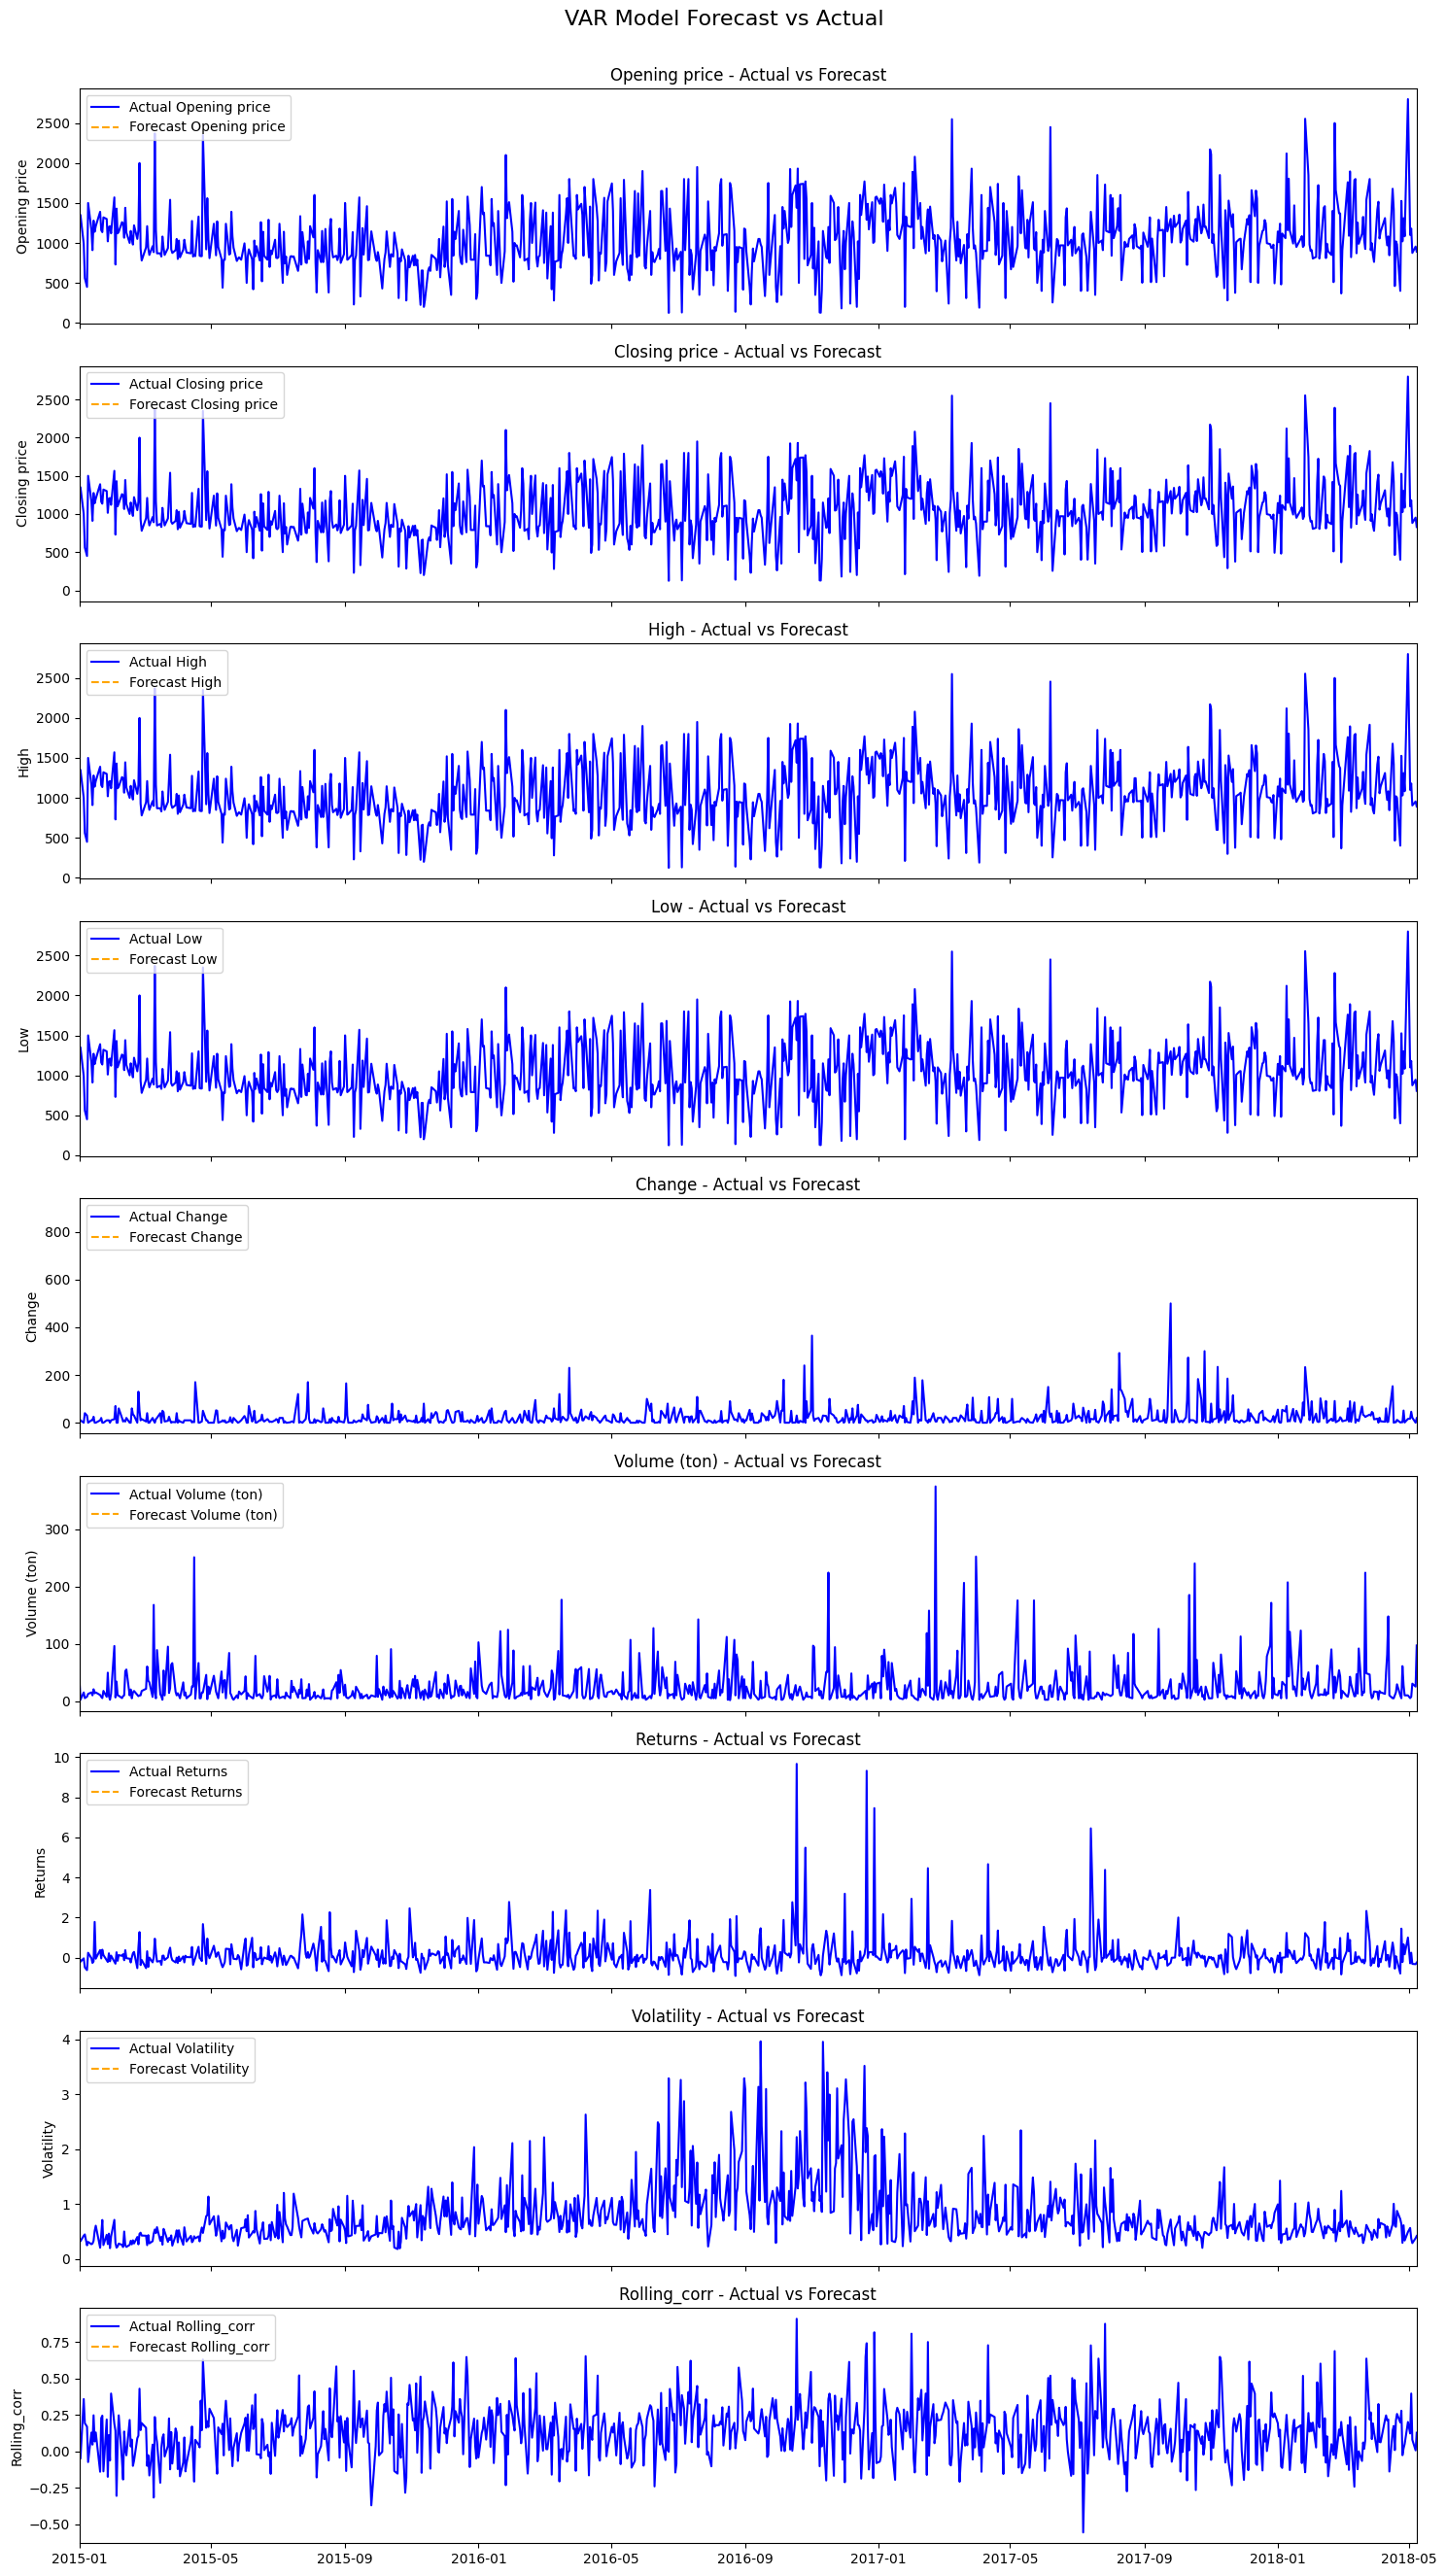

In [11]:
train_data = train

variables = train_data.columns  # ['Opening price', 'Closing price', 'High', 'Low', 'Change', 'Volume', 'returns', 'volatility']
num_vars = len(variables)

fig, axes = plt.subplots(num_vars, 1, figsize=(15, num_vars * 3), sharex=True)

for i, var in enumerate(variables):
    # Plot actual values
    axes[i].plot(train_data.index, train_data[var], label=f'Actual {var.capitalize()}', color='blue')
    
    # Plot forecasted values (shifted to match the forecast period)
    forecast_index = pd.date_range(start=train_data.index[-1], periods=len(forecast_df)+1, freq='B')[1:]  # Assuming business day frequency
    axes[i].plot(forecast_index, forecast_df[var], label=f'Forecast {var.capitalize()}', linestyle='--', color='orange')

    # Add legend and labels
    axes[i].legend(loc='upper left')
    axes[i].set_title(f'{var.capitalize()} - Actual vs Forecast')
    axes[i].set_ylabel(var.capitalize())

# Set a limit for the x-axis if needed to zoom in on recent data
axes[-1].set_xlim(pd.Timestamp('2015-01-01'), train_data.index[-1])

# Improve spacing and layout
fig.tight_layout()
fig.suptitle("VAR Model Forecast vs Actual", fontsize=16)
fig.subplots_adjust(top=0.95)  # Adjust to fit the suptitle

# Show the plot
plt.show()

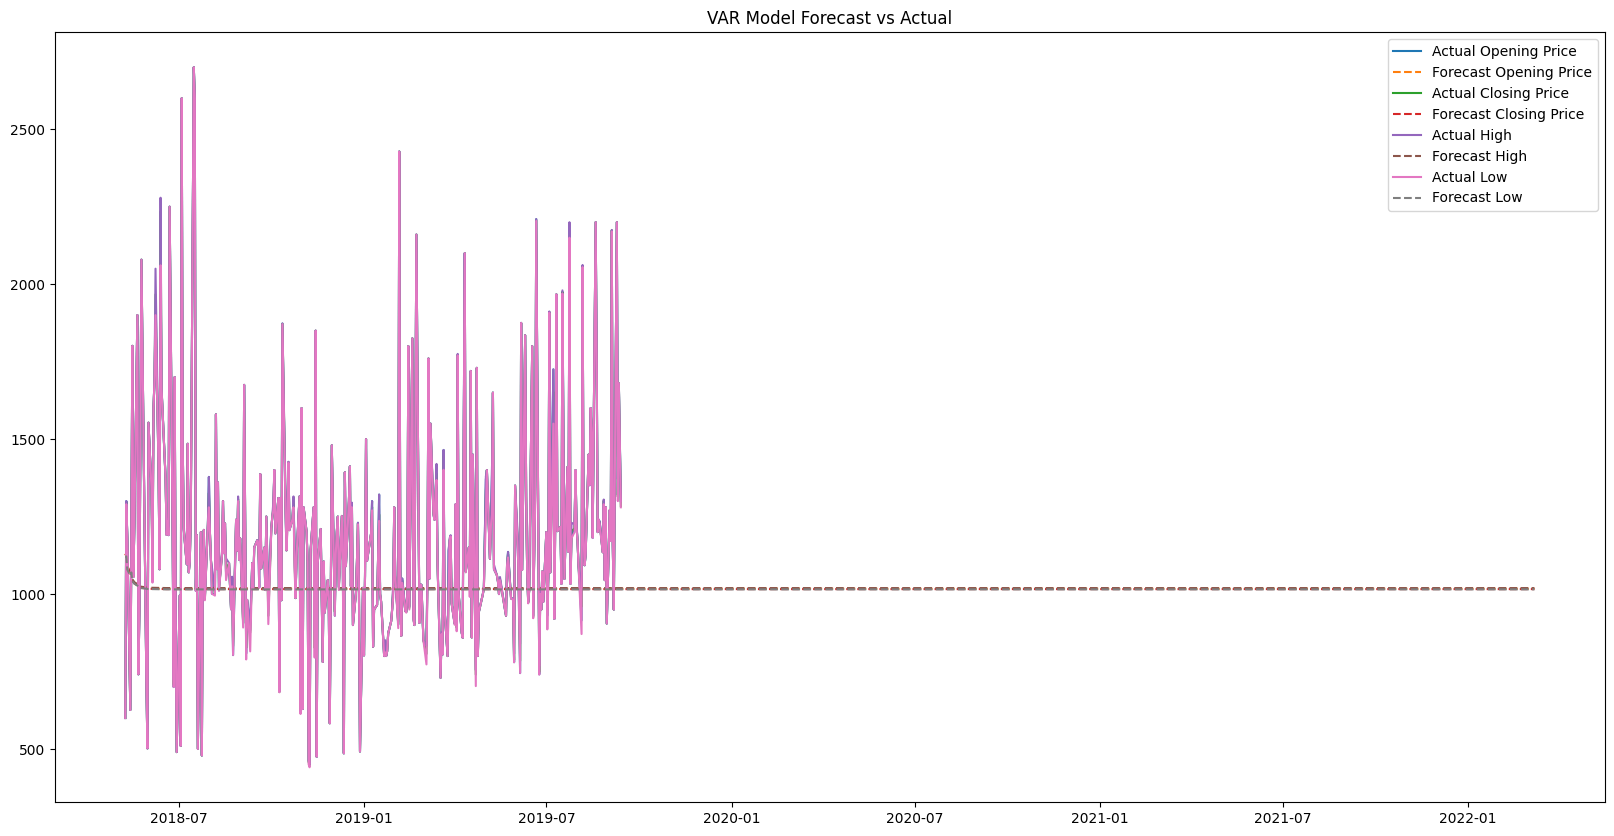

In [13]:
# Plotting actual vs predicted values for model evaluation
def plot_forecast_vs_actual(train, test, forecast_df, columns):
    plt.figure(figsize=(20, 10))
    for col in columns:
        plt.plot(test.index, test[col], label=f'Actual {col}')
        forecast_index = pd.date_range(start=train.index[-1], periods=len(forecast_df)+1, freq='B')[1:]
        plt.plot(forecast_index, forecast_df[col], label=f'Forecast {col}', linestyle='--')
    plt.legend()
    plt.title("VAR Model Forecast vs Actual")
    plt.show()

# Columns to plot
columns = ['Opening Price', 'Closing Price', 'High', 'Low']

# Plotting and evaluating
plot_forecast_vs_actual(train, test, forecast_df, columns)


In [14]:
# Model evaluation function with extended metrics
def evaluate_model(test, forecast_df, recency_window=5):
    evaluation_metrics = {}
    forecast_df = forecast_df.iloc[:len(test)]

    for col in test.columns:
        # Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(test[col].iloc[:len(forecast_df)], forecast_df[col]))
        
        # Mean Absolute Error (MAE)
        mae = mean_absolute_error(test[col].iloc[:len(forecast_df)], forecast_df[col])
        
        # Mean Absolute Percentage Error (MAPE)
        mape = mean_absolute_percentage_error(test[col].iloc[:len(forecast_df)], forecast_df[col])
        
        # Recency RMSE (last 'recency_window' points)
        recent_rmse = np.sqrt(mean_squared_error(test[col].iloc[-recency_window:], forecast_df[col].iloc[-recency_window:]))

        evaluation_metrics[col] = {
            'Root Mean Squared Error ': rmse,
            'Mean Absolute Error ': mae,
            'Mean Absolute Percentage Error': mape,
            'Recency RMSE': recent_rmse
        }
        
        # Print the metrics
        print(f"Metrics for {col}:")
        print(f"  Root Mean Squared Error: {rmse}")
        print(f"  Mean Absolute Error: {mae}")
        print(f"  Mean Absolute Percentage Error: {mape}")
        print(f"  Recency RMSE (last {recency_window} values): {recent_rmse}\n")
        
    return evaluation_metrics

rmses = evaluate_model(test, forecast_df)

Metrics for Opening Price:
  Root Mean Squared Error: 408.28420253971524
  Mean Absolute Error: 277.5048721831184
  Mean Absolute Percentage Error: 0.22189102336051564
  Recency RMSE (last 5 values): 634.7619684237391

Metrics for Closing Price:
  Root Mean Squared Error: 409.63466327261773
  Mean Absolute Error: 277.2337949890138
  Mean Absolute Percentage Error: 0.22125351217173847
  Recency RMSE (last 5 values): 633.7101077277947

Metrics for High:
  Root Mean Squared Error: 410.98202838932946
  Mean Absolute Error: 278.24575846971425
  Mean Absolute Percentage Error: 0.22052807913766878
  Recency RMSE (last 5 values): 638.407686142358

Metrics for Low:
  Root Mean Squared Error: 406.7143400994289
  Mean Absolute Error: 275.6118617671972
  Mean Absolute Percentage Error: 0.2221273469445288
  Recency RMSE (last 5 values): 632.7440454696009

Metrics for Change:
  Root Mean Squared Error: 45.87544357003498
  Mean Absolute Error: 27.662019257847334
  Mean Absolute Percentage Error: 1.21